To run this, please go down a couple slots, go to the place where directories are made and image data are copied to the new directories. Then, please adjust the source directory for the image data to your local one, using the data set that came with this notebook.

In [ ]:
# A big chunk of the code was obtained from the following amazing Kaggle code, and tweaked!
# https://www.kaggle.com/code/prannayagupta/augmentation-assisted-transfer-learning/notebook

import random
import os
import shutil

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

# to display example images & reading image in using k-fold from sklearn
from PIL import Image

from torchvision.utils import make_grid

# for confusion matrix
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# TO RUN THIS NOTEBOOK, PLEASE ADJUST THE LINE BELOW TO POINT TO THE DATA FILE OF YOUR OWN
google_source_folder = "/content/drive/MyDrive/REX"

Mounted at /content/drive


In [ ]:
!rm -rf data

In [ ]:
# Setting up data by copying from google drive
data_folder = "data"
dom_nondom = ["dom", "nondom"]

if data_folder not in os.listdir():
  os.mkdir(data_folder)
  for fol in dom_nondom:
      os.mkdir(f"{data_folder}/{fol}")
else:
  print("Data already copied!")

for fol in dom_nondom:
  for file in os.listdir(f"{google_source_folder}/white_on_black/all_image/{fol}"):
    shutil.copy(
        f"{google_source_folder}/white_on_black/all_image/{fol}/{file}",
        f"{data_folder}/{fol}/{file.replace('_', '')}" #remove all "_" to allow following code to run properly
        )

## Noise Addition

We use this increase the size of the dataset.

In [ ]:
def apply_noise(noise_type, image):
    if noise_type == "gauss":
        row, col, ch = image.shape
        mean = 0
        sigma = random.randint(10, 100)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        noisy = image + gauss
        return noisy
    elif noise_type == "s&p":
        row, col, ch = image.shape

        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)

        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in (row, col, ch)]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in (row, col, ch)]
        out[coords] = 0
        return out
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_type == "speckle":
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)
        noisy = image + image * gauss * 0.2
        return noisy

In [ ]:
def motionBlur(img, vertical = True):
    kernel_size = random.randint(20, 35)
    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_h = np.copy(kernel_v)
    kernel_v[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel_v /= kernel_size
    kernel_h /= kernel_size
    return cv2.filter2D(img, -1, kernel_v) if vertical else cv2.filter2D(img, -1, kernel_h)

def pixelate(img):
    height, width = img.shape[:2]
    w, h = (random.randint(100, 150), random.randint(100, 150))
    temp = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
    return cv2.resize(temp, (width, height), interpolation=cv2.INTER_NEAREST)

def normalBlur(img):
    return cv2.blur(img, (random.randint(7, 35), random.randint(7, 35)))

def darken(img):
    return img + random.randint(-50, -1)

def lighten(img):
    return img + random.randint(1, 50) #Have to control against value going over 250 if we are going to use it

def gauss(img):
    return apply_noise("gauss", img)

def speckle(img):
    return apply_noise("speckle", img)

We can apply those transformations to create new images in the respective folders.

In [ ]:
# Applying the transformation to create new images in the respective folders
from scipy import ndimage

def create_images_with_noise_transformation(src : str, writeTo : str):
  """
  Creates images based on the original image obtained by reading the file at src,
  by applying noise transformations defined above, to be written into files at writeTo.

  :param str src: Path to the source image file.
  :param str writeTo: The directory to render the image into.
  """
  img = cv2.imread(f"{src}")
  for ext in ['.png', '.jpg']:
    if file.endswith(ext):
      starter = file.replace(ext, '')
      cv2.imwrite(f"{writeTo}/{starter}_motionV{ext}", motionBlur(img))
      cv2.imwrite(f"{writeTo}/{starter}_motionH{ext}", motionBlur(img, False))
      cv2.imwrite(f"{writeTo}/{starter}_pixelate{ext}", pixelate(img)) #might be compromising data quality for our example
      cv2.imwrite(f"{writeTo}/{starter}_normal{ext}", normalBlur(img))
      cv2.imwrite(f"{writeTo}/{starter}_dark{ext}", darken(img))
      # cv2.imwrite(f"{writeTo}/{starter}_light{ext}", lighten(img)) #original image too light to be any useful
      # cv2.imwrite(f"{writeTo}/{starter}_gauss{ext}", gauss(img)) #creates weird images so won't use
      cv2.imwrite(f"{writeTo}/{starter}_speckle{ext}", speckle(img))

def create_images_with_rotation_transformation(src : str, writeTo : str):
  """
  Creates images based on the original image obtained by reading the file at src,
  by applying rotation transformations, to be written into files at writeTo.

  :param str src: Path to the source image file.
  :param str writeTo: The directory to render the image into.
  """
  img = cv2.imread(f"{src}")
  for ext in ['.png', '.jpg']:
    if file.endswith(ext):
      starter = file.replace(ext, '')

      interval = 10 #interval of rotation in degrees
      for x in range(interval, 360, interval):
        cv2.imwrite(f"{writeTo}/{starter}_rotate{x}degree{ext}", ndimage.rotate(img, angle=x, reshape=False))

for fol in dom_nondom:
  for file in os.listdir(f"{data_folder}/{fol}"):
    # making sure we don't make images for images already augmented once
    if "_" in file: continue

    # create_images_with_noise_transformation(src=f"{data_folder}/{fol}/{file}", writeTo=f"{data_folder}/{fol}")
    create_images_with_rotation_transformation(src=f"{data_folder}/{fol}/{file}", writeTo=f"{data_folder}/{fol}")

In [ ]:
# Some quick code to store the resulting imageset into datasets, if need be
STORE_CURRENT_IMAGES_AS_DATASET = False
if STORE_CURRENT_IMAGES_AS_DATASET:
  all_dom_ds = tf.keras.utils.image_dataset_from_directory(
          f"{data_folder}/dom",
          labels=None,
          color_mode='rgb',
          batch_size=None,
          interpolation='bilinear'
          )
  all_nondom_ds = tf.keras.utils.image_dataset_from_directory(
          f"{data_folder}/nondom",
          labels=None,
          color_mode='rgb',
          batch_size=None,
          interpolation='bilinear'
          )

  all_dom_ds.save("all_dominant_hand_data")
  all_nondom_ds.save("all_non_dominant_hand_data")

Once we've got the new images, we can create datasets out of their directories using image_dataset_from_directory.

In [ ]:
"""
New flow:
1) two folders holding two sets of images, one for dominant and other for non dominant <- DONE AT THIS POINT!
2) we augment them by producing the new images <- DONE AT THIS POINT!
3) shuffle the whole folder
4) allocate 80% of non-dom in train & test, and 20% in validation (or whatever ratio we like)
5) allocate the same number of validation images for dom, then allocate the rest into train & test
6) split the train & test dataset into k, such that we can perform k-fold cross-validation on them.
"""

def obtain_dataset_split_into_k_traintest_and_val(
    k : int,
    dir : str = None,
    dom_dataset_path : str = None,
    non_dom_dataset_path : str = None,
    seed : int = 123,
    batch_size : int = 8,
    val_ratio : float = 0.2
    ):
  """
  Returns a dataset split into k equal train-test datasets to use for k-fold cross validation,
  as well as a validation dataset to judge performance at the end.

  The data is obtained either from:
  - dir if it is not None.
  dir should hold both 'dom' and 'nondom' subdirectories which hold the corresponding images.
  - dom_dataset_path & non_dom_dataset_path if dir is None.
  They are paths to the corresponding dataset objects to be loaded.
  If either of the two don't work correctly, an error is raised.

  Returns a tuple of ((k equally size datasets), validation_datset).
  The result is shuffled based on the given seed / randomly if seed is None.

  If k = 1, returns a tuple holding ((train, test), validation_dataset) where train/test
  datasets are obtained by dividing the dataset after isolating the validation dataset into
  VANILLA_TRAIN_RATIO / VANILLA_TEST_RATIO, as defined in this function body.

  :param str dir: The directory holding two subfolders 'dom' and 'nondom' holding the images.
  :param str dom_dataset: The path to the dominant image dataset. Checked if dir is None.
  :param str non_dom_dataset: The path to the non-dominant image dataset. Checked if dir is None.
  :param int k: The number of datasets into which we split the train-test part.
   If k = 1, returns ((train, test), validation) where train/test datasets are
   VANILLA_TRAIN_RATIO : VANILLA_TEST_RATIO in ratio as defined in this function body.
  :param int seed: The seed for shuffling the datasets when they are created.
  :param int batch_size: The size of batches of data in the datasets, if specified.
  :param float val_ratio: The ratio of the dataset that is put into the validation dataset.
  (1 - val_ratio) will be put into the train/test dataset and split into k.
  """
  if dir == None and (dom_dataset_path == None or non_dom_dataset_path == None):
    raise Exception("One of dir, or dom_dataset & non_dom_dataset have to be valid entries!")

  if 0 > val_ratio or val_ratio > 1:
    raise Exception("val_ratio is set to an invalid value; please set it between 0 and 1!")
  train_test_ratio = 1 - val_ratio

  INPUT_SIZE = (224, 224)
  DOM_LABEL = 0
  NONDOM_LABEL = (1 - DOM_LABEL)
  SHUFFLE_BFS = 1000
  # ratio to split the dataset after validation set is isolated when k = 1
  VANILLA_TRAIN_RATIO = 0.75; VANILLA_TEST_RATIO = (1 - VANILLA_TRAIN_RATIO)

  # white on black image datasets with rgb color mode; since models have been trained on ImageNet
  # which has RGB images, we don't benefit for converting images into greyscale

  # NONDOMINANT IMAGES
  # first read all nondom images into a dataset
  if dir != None:
    all_nondom_ds = tf.keras.utils.image_dataset_from_directory(
        f"{dir}/nondom",
        labels=None,
        color_mode='rgb',
        batch_size=1, #will batch further later
        image_size=INPUT_SIZE,
        shuffle=True,
        seed=seed,
        interpolation='bilinear'
    # for some reason, by adding an additional batch dimension, we can prevent each image
    # in the dataset from splitting into 224 individual arrays
    ).batch(1)

    # create a dataset of dom images
    all_dom_ds = tf.keras.utils.image_dataset_from_directory(
        f"{dir}/dom",
        labels=None,
        color_mode='rgb',
        batch_size=1, #will batch further later
        image_size=INPUT_SIZE,
        shuffle=True,
        seed=seed,
        interpolation='bilinear'
    # for some reason, by adding an additional batch dimension, we can prevent each image
    # in the dataset from splitting into 224 individual arrays
    ).batch(1)

  else:
    all_nondom_ds = tf.data.Dataset.load(
        non_dom_dataset_path
      ).batch(
        1
      ).map(
        lambda img : tf.image.resize(img, size=INPUT_SIZE, method=tf.image.ResizeMethod.BILINEAR)
      ).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(1)

    all_dom_ds = tf.data.Dataset.load(
        dom_dataset_path
      ).batch(
        1
      ).map(
        lambda img : tf.image.resize(img, size=INPUT_SIZE, method=tf.image.ResizeMethod.BILINEAR)
      ).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(1)

  all_nondom_size = int(all_nondom_ds.cardinality().numpy())
  train_test_nondom_size = int(all_nondom_size * train_test_ratio)
  val_nondom_size = all_nondom_size - train_test_nondom_size

  # then split this into train & test set and val set with specified ratio
  train_test_nondom_ds, val_nondom_ds = tf.keras.utils.split_dataset(
      all_nondom_ds, left_size=train_test_nondom_size
  )

  # add labels to each data
  train_test_nondom_ds = train_test_nondom_ds.map(lambda img : (tf.squeeze(img, axis=0), NONDOM_LABEL))
  val_nondom_ds        =        val_nondom_ds.map(lambda img : (tf.squeeze(img, axis=0), NONDOM_LABEL))

  # DOMINANT IMAGES
  # split it such that there are the same number of train&test and val data as nondom
  train_test_dom_ds, val_dom_ds = tf.keras.utils.split_dataset(
      all_dom_ds, right_size=val_nondom_size
  )

  # add labels to each data
  train_test_dom_ds = train_test_dom_ds.map(lambda img : (tf.squeeze(img, axis=0), DOM_LABEL))
  val_dom_ds        =        val_dom_ds.map(lambda img : (tf.squeeze(img, axis=0), DOM_LABEL))

  # split the train_test datasets for each class into k (mostly) equal parts
  train_test_dom_size = int(train_test_dom_ds.cardinality().numpy())
  dom_single_ds_size, nondom_single_ds_size = train_test_dom_size // k, train_test_nondom_size // k

  dom_rest_to_split, nondom_rest_to_split = train_test_dom_ds, train_test_nondom_ds
  k_ds = []

  # if k = 1, simply split the remaining dataset into the VANILLA_TRAIN/TEST_RATIO
  if k == 1:
    dom_train_ds, dom_test_ds = tf.keras.utils.split_dataset(
        dom_rest_to_split, left_size=int(dom_single_ds_size * VANILLA_TRAIN_RATIO)
        )
    nondom_train_ds, nondom_test_ds = tf.keras.utils.split_dataset(
        nondom_rest_to_split, left_size=int(nondom_single_ds_size * VANILLA_TRAIN_RATIO)
        )
    # merge & shuffle & rebatch the dom/nondom ds to create a single ds
    train_ds = dom_train_ds.concatenate(nondom_train_ds).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(batch_size)
    test_ds  =  dom_test_ds.concatenate(nondom_test_ds ).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(batch_size)
    k_ds.append((train_ds, test_ds))

  # otherwise do the split normally
  else:
    for i in range(k - 1):
      new_dom_ds, dom_rest_to_split = tf.keras.utils.split_dataset(
          dom_rest_to_split, left_size=dom_single_ds_size
          )
      new_nondom_ds, nondom_rest_to_split = tf.keras.utils.split_dataset(
          nondom_rest_to_split, left_size=nondom_single_ds_size
      )
      # merge & shuffle & rebatch the dom/nondom ds to create a single ds for each split
      new_ds = new_dom_ds.concatenate(new_nondom_ds).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(batch_size)
      k_ds.append(new_ds)
      # if we reach the end of iteration, the 'rest' dataset are included into the dataset
      if i == (k - 2):
        last_ds = dom_rest_to_split.concatenate(nondom_rest_to_split).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(batch_size)
        k_ds.append(last_ds)

  # finally, merge & shuffle val dataset to create the final dataset
  val_ds = val_dom_ds.concatenate(val_nondom_ds).shuffle(buffer_size=SHUFFLE_BFS, seed=seed).batch(batch_size)

  return tuple(k_ds), val_ds


def get_k_train_test_datasets(datasets, shuffle=True, seed=123):
  """
  Taking a list of k datasets (assumed to be obtained by
  splitting a dataset into k equal parts), forms k datasets where
  the ith dataset is returned as test dataset, and all
  other (k - 1) datasets are merged into a train dataset.

  That is, given datasets 1~4, we return:

  ( (merge(1, 2, 3), 4), (merge(1, 2, 4), 3),
    (merge(1, 3, 4), 2), (merge(2, 3, 4), 1) )

  :param List[tf.data.Dataset] datasets: The set of datasets we are creating
  train/test datasets from.
  :param bool shuffle: Whether to shuffle the train & test datasets
  before returning their pairs.
  :param int seed: Seed by which we shuffle the datasets, if we do.
  """
  SHUFFLE_BFS = 1000
  # trivial case where the datasets is None / only has one dataset
  if len(datasets) <= 1:
    return datasets

  ret = []
  # for every rotation, one ds is chosen for test
  for j in range(len(datasets)):
    i = len(datasets) - j - 1
    # merge the rest
    datasets_to_be_merged = datasets[:i] + datasets[i+1:]
    train_ds = datasets_to_be_merged[0]; [train_ds := train_ds.concatenate(dsm) for dsm in datasets_to_be_merged[1:]]

    test_ds = datasets[i]
    # shuffle if needed
    if shuffle: train_ds, test_ds = train_ds.shuffle(buffer_size=SHUFFLE_BFS, seed=seed), test_ds.shuffle(buffer_size=SHUFFLE_BFS, seed=seed)
    ret.append((train_ds, test_ds))

  return tuple(ret)

In [ ]:
# """
# TRYING TO IMPLEMENT IT BUT THEN ITS SO HARD AND TEDIOUS AND FEELS UNNEEDED THAT I MIGHT JUST LEAVE IT UNTIL THE END
# Realized that they have an scikit-learn implementation of stratified k-fold - exactly what I needed.
# Use it to ensure that my code didn't have any bugs in it.
# """
# from sklearn.model_selection import StratifiedKFold
# from numpy.random import default_rng

# def obtain_dataset_split_into_k_traintest_and_val_using_sklearn(
#     k : int,
#     seed : int = 123,
#     batch_size : int = 8,
#     val_ratio : float = 0.2
#     ):
#   """
#   Uses scikit-learn's stratified k fold functionality internally!!!

#   Returns k pairs of (train, test) datasets created to use for k-fold cross validation,
#   as well as a validation dataset to judge performance at the end.
#   Returns a tuple of ((train, test) * k, validation_datset).
#   The result is shuffled based on the given seed / randomly if seed is None.

#   :param int k: The number of datasets into which we split the train-test part.
#   :param int seed: The seed for shuffling the datasets when they are created.
#   :param int batch_size: The size of batches of data in the datasets, if specified.
#   :param float val_ratio: The ratio of the dataset that is put into the validation dataset.
#   (1 - val_ratio) will be put into the train/test dataset and split into k.
#   """
#   INPUT_SIZE = (224, 224)
#   DOM_LABEL = 0
#   NONDOM_LABEL = (1 - DOM_LABEL)

#   if 0 > val_ratio or val_ratio > 1:
#     raise Exception("val_ratio is set to an invalid value; please set it between 0 and 1!")
#   train_test_ratio = 1 - val_ratio

#   # white on black image datasets with rgb color mode; since models have been trained on ImageNet
#   # which has RGB images, we don't benefit for converting images into greyscale

#   # we read images in the two directories, building an array of images for each class
#   dom_image_array, non_dom_image_array = [], []

#   for dir in ["dom", "nondom"]:
#     dir_path = f"{data_folder}/{dir}"
#     for f in os.listdir(dir_path):
#       img = tf.keras.preprocessing.image.load_img(dir_path + "/" + f)
#       img_data = tf.keras.preprocessing.image.img_to_array(img)
#       dom_image_array.append(img_data) if (dir == "dom") else non_dom_image_array.append(img_data)

#   dom_image_array, non_dom_image_array = np.asarray(dom_image_array), np.asarray(non_dom_image_array)
#   print("dom_image_array size: ", np.size(dom_image_array, axis=0))
#   print("non_dom_image_array size: ", np.size(non_dom_image_array, axis=0))

#   # First isolate the validation set
#   rng = default_rng(seed)
#   dom_size, non_dom_size = np.size(dom_image_array, axis=0), np.size(non_dom_image_array, axis=0)
#   dom_val_size, non_dom_val_size = int(val_ratio * dom_size), int(val_ratio * non_dom_size)
#   print("dom_val_size, non_dom_val_size: ", dom_val_size, non_dom_val_size)
#   # sample indices without replacement
#   dom_val_indices     = rng.choice(dom_size,     size=dom_val_size     ,replace=False, shuffle=False)
#   non_dom_val_indices = rng.choice(non_dom_size, size=non_dom_val_size ,replace=False, shuffle=False)
#   print("dom_val_indices, non_dom_val_indices: ", dom_val_indices, non_dom_val_indices)
#   # isolate image data based on sampled indices
#   dom_val_imgs, non_dom_val_imgs = np.take(dom_image_array, dom_val_indices), np.take(non_dom_image_array, non_dom_val_indices)
#   print("dom_val_imgs, non_dom_val_imgs sizes: ", np.size(dom_val_imgs, axis=0), np.size(non_dom_val_imgs, axis=0))
#   dom_rest_imgs, non_dom_rest_imgs = np.delete(dom_image_array, dom_val_indices), np.delete(non_dom_image_array, non_dom_val_indices)
#   print("dom_rest_imgs, non_dom_rest_imgs sizes: ", np.size(dom_rest_imgs, axis=0), np.size(non_dom_rest_imgs, axis=0))
#   # create appropriate labels
#   dom_val_lbls, non_dom_lbls = np.full(shape=dom_val_size, fill_value=DOM_LABEL), np.full(shape=non_dom_val_size, fill_value=NON_DOM_LABEL)
#   print("dom_val_lbls, non_dom_lbls: ", dom_val_lbls, non_dom_lbls)
#   # create the validation dataset
#   val_imgs, val_lbls = np.concatenate(dom_val_imgs, non_dom_val_imgs), np.concatenate(dom_val_lbls, non_dom_lbls)
#   val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_lbls)).shuffle(buffer_size=1000, seed=seed).batch(batch_size)

#   # # Then we use stratified k fold to get indices of split, generate train & test datasets
#   # # and merge & return them
#   # train_test_datasets = []
#   # skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
#   # for _ in range(k):
#   #   train_idx, test_idx = skf.split(
#   #       np.zeros(label_array.size), #place holder to get indices
#   #       label_array
#   #       )
#   #   # get the images & labels using the indices obtained
#   #   train_img_np, test_img_np = np.take(image_array, train_idx), np.take(image_array, test_idx)
#   #   train_lbl_np, test_lbl_np = np.take(label_array, train_idx), np.take(label_array, test_idx)
#   #   # create the train & test datasets using those
#   #   train_ds = tf.data.Dataset.from_tensor_slices((train_img_np, train_lbl_np)).batch(batch_size)
#   #   test_ds  = tf.data.Dataset.from_tensor_slices(( test_img_np,  test_lbl_np)).batch(batch_size)
#   #   train_test_datasets.append((train_ds, test_ds))

#   # return tuple(train_test_datasets), val_ds


In [ ]:
# # for debug; remove later!
# datasets, val_ds = obtain_dataset_split_into_k_traintest_and_val_using_sklearn(k=5, seed=123, batch_size=8, val_ratio=0.2)
# # split_datasets, val_ds = obtain_dataset_split_into_k_traintest_and_val(k=4, seed=123)
# # datasets = get_k_train_test_datasets(split_datasets, shuffle=True, seed=123)

# def show_k_images_from_dataset(ds, k : int = 5):
#   it = iter(ds)
#   for i in range(k):
#     try:
#       images, labels = next(it)
#       print("Data pair ", i + 1, "!")
#     except:
#       break

#     show_image_grid(images, 4)
#     print(labels)

# # show some couple examples from the datasets we obtained
# HOW_MANY_IMG_TO_SHOW = 3

# for num, ds in enumerate(datasets):
#   print("Dataset pair ", num + 1, "!")

#   train_ds, test_ds = ds
#   print("Train dataset, holding ", train_ds.cardinality().numpy(), "data / batches of data: ")
#   show_k_images_from_dataset(train_ds, HOW_MANY_IMG_TO_SHOW)

#   print("Test dataset, holding ", test_ds.cardinality().numpy(), "data / batches of data: ")
#   show_k_images_from_dataset(test_ds, HOW_MANY_IMG_TO_SHOW)

# print("Validation dataset, , holding ", val_ds.cardinality().numpy(), "data / batches of data!")
# show_k_images_from_dataset(val_ds, HOW_MANY_IMG_TO_SHOW)

In [ ]:
# function that takes a tensor of batch of images and display them!
def show_image_grid(t : tf.Tensor, grid_width):
  """
  t is of the form (batch_size, width, height, channel) or the alike.
  """
  # t = tf.cast(t, tf.int64) #casting as we end up ultimately displaying it <- with it, images look very dark for some reason
  single_images_with_extra_dim = tf.split(t, num_or_size_splits=int(tf.shape(t)[0]), axis=0)
  single_images = [tf.squeeze(image) for image in single_images_with_extra_dim]
  padding_size = grid_width - ((len(single_images) - 1) % grid_width) - 1
  if padding_size != 0: single_images.extend( [tf.ones(tf.shape(t)[1:4], dtype=t.dtype)] * padding_size)
  rows = [single_images[i*grid_width : (i+1)*grid_width]
          for i in range( (len(single_images) - 1) // grid_width + 1)]
  row_tensors = [tf.concat(row, axis=1) for row in rows]
  grid = tf.concat(row_tensors, axis=0)
  plt.imshow(
      grid.numpy(),
      cmap='gray',
      vmin=0,
      vmax=255
    )
  plt.show()

In [ ]:
# Useful for debugging, but it will eat a lot of RAM - so only include if we need demonstration
# # split_datasets, val_ds = obtain_dataset_split_into_k_traintest_and_val(k=4, dir=data_folder, seed=123)
# split_datasets, val_ds = obtain_dataset_split_into_k_traintest_and_val(
#     k=1,
#     dir=data_folder,
#     # dom_dataset_path="all_dominant_hand_data",
#     # non_dom_dataset_path="all_non_dominant_hand_data",
#     seed=123
#     )

# datasets = get_k_train_test_datasets(split_datasets, shuffle=True, seed=123)

# def show_k_images_from_dataset(ds, k : int = 5):
#   it = iter(ds)
#   for i in range(k):
#     try:
#       images, labels = next(it)
#       print("Data pair ", i + 1, "!")
#     except:
#       break

#     show_image_grid(images, 4)
#     print(labels)

# # show some couple examples from the datasets we obtained
# HOW_MANY_IMG_TO_SHOW = 3

# for num, ds in enumerate(datasets):
#   print("Dataset pair ", num + 1, "!")

#   train_ds, test_ds = ds
#   print("Train dataset, holding ", train_ds.cardinality().numpy(), "data / batches of data: ")
#   show_k_images_from_dataset(train_ds, HOW_MANY_IMG_TO_SHOW)

#   print("Test dataset, holding ", test_ds.cardinality().numpy(), "data / batches of data: ")
#   show_k_images_from_dataset(test_ds, HOW_MANY_IMG_TO_SHOW)

# print("Validation dataset, , holding ", val_ds.cardinality().numpy(), "data / batches of data!")
# show_k_images_from_dataset(val_ds, HOW_MANY_IMG_TO_SHOW)

In [ ]:
tf.get_logger().setLevel('INFO')

import csv
import tensorflow.keras.backend as K
from tensorflow import keras
import os

class StoreModelHistory(keras.callbacks.Callback):
    def __init__(self, model_directory):
        super().__init__()
        self.model_directory = model_directory

    def on_epoch_end(self,batch,logs=None):
        if ('lr' not in logs.keys()):
            logs.setdefault('lr',0)
            logs['lr'] = K.get_value(self.model.optimizer.lr)

        if not ('model_history.csv' in os.listdir(self.model_directory)):
            with open(self.model_directory+'model_history.csv','a') as f:
                y = csv.DictWriter(f,logs.keys())
                y.writeheader()

        with open(self.model_directory+'model_history.csv','a') as f:
            y = csv.DictWriter(f,logs.keys())
            y.writerow(logs)

In [ ]:
import matplotlib.pyplot as plt

def train(
    model_name : str,
    base_model : keras.Model,
    epochs : int,
    learning_rate : float,
    trainable : bool,
    train_ds : tf.data.Dataset,
    test_ds : tf.data.Dataset,
    binary_or_two_class : str = "binary", #"binary" or "two_class"
    show_hist : bool = True
    ):
    base_model.trainable = trainable

    # TOREMOVE: EXPERIMENTALLY ADDED CODE
    # essentially allowing all layers in the last convolution layer
    # to adapt to the task
    # base_model.trainable = True
    # for l in base_model.layers:
    #   if model_name == "resnet50": l.trainable = l._name.startswith("conv5")
    #   if model_name == "mobilenet-v3-large": l.trainable = l._name.startswith("Conv_1")
    #   if model_name == "mobilenet-v3-small": l.trainable = l._name.startswith("Conv_1")
    # END OF EXPERIMENTALLY ADDING CODE

    inputs = Input(shape=(224, 224, 3))
    x = inputs

    x = base_model.call(x)
    x = GlobalAveragePooling2D()(x)

    out_num, activ = (2, "softmax") if (binary_or_two_class == "two_class") else (1, "sigmoid")
    outputs = Dense(out_num, activation=activ)(x)

    model = Model(inputs=inputs, outputs=outputs)

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = "sparse_categorical_crossentropy" if (binary_or_two_class == "two_class") else "binary_crossentropy"
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

    try: os.mkdir(f"logs/{model_name}/")
    except: pass
    history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[StoreModelHistory(f"logs/{model_name}/")])

    if show_hist:
      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()
      # summarize history for loss
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'test'], loc='upper left')
      plt.show()

    # save the actual model
    model.save(f"{model_name}-retrained.h5")

    return history, model

In [ ]:
def k_fold_cross_validate(
    datasets,
    model_name : str,
    base_model : keras.Model,
    epochs : int,
    learning_rate : float,
    trainable : bool,
    binary_or_two_class : str = "binary", #"binary" or "two_class"
    show_hist_after_each_train : bool = False
    ):
  """
  Performs k-fold cross validation on the given model & name, given a list of
  dataset "datasets" which holds some number of equally split datasets.
  TODO ADD PARAMS!
  """
  trained_models = {}
  histories = []

  # train the models on every train/test pairs
  for i in range(len(datasets)):
    print("Dataset pair ", i+1, "!")
    model_to_be_trained = base_model(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
        )

    ith_model_name = model_name + "_" + str(i+1) + "th_ds"
    train_ds, test_ds = datasets[i]

    hist, trained_model = train(
        model_name=ith_model_name,
        base_model=model_to_be_trained,
        epochs=EPOCHS,
        learning_rate = learning_rate,
        trainable=trainable,
        train_ds=train_ds,
        test_ds=test_ds,
        binary_or_two_class=binary_or_two_class,
        show_hist=show_hist_after_each_train
        )
    trained_models[ith_model_name] = trained_model
    histories.append(hist)

  print("average last accuracy: ",     sum([h.history['accuracy'][-1]     for h in histories]) / len(histories))
  print("average last val_accuracy: ", sum([h.history['val_accuracy'][-1] for h in histories]) / len(histories))
  print("average last loss: ",     sum([h.history['loss'][-1]     for h in histories]) / len(histories))
  print("average last val_loss: ", sum([h.history['val_loss'][-1] for h in histories]) / len(histories))
  # average accuracy over time
  avg_accuracy     = [sum([h.history['accuracy'][i]     for h in histories]) / len(histories) for i in range(len(histories[0].history['accuracy']))]
  avg_val_accuracy = [sum([h.history['val_accuracy'][i] for h in histories]) / len(histories) for i in range(len(histories[0].history['val_accuracy']))]
  # average loss over time
  avg_loss     = [sum([h.history['loss'][i]     for h in histories]) / len(histories) for i in range(len(histories[0].history['loss']))]
  avg_val_loss = [sum([h.history['val_loss'][i] for h in histories]) / len(histories) for i in range(len(histories[0].history['val_loss']))]

  plt.plot(avg_accuracy)
  plt.plot(avg_val_accuracy)
  plt.title('average model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(avg_loss)
  plt.plot(avg_val_loss)
  plt.title('average model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  return trained_models, histories

In [ ]:
# TRIAL ADDITION OF A SELF-CREATED CONV NET
def get_original_convnet(input_shape=(224, 224, 3), include_top=False, **kwargs): #**kwargs there for compatibility (such as keyword weights)
  """
  Creates an original conv net for trial.
  """
  original_convnet = Sequential()
  original_convnet.add(Input(shape=input_shape))

  original_convnet.add(Conv2D(filters=32, kernel_size=5, strides=1, activation="relu")) #224x224->220x220
  original_convnet.add(MaxPooling2D(2)) #->110x110

  original_convnet.add(Conv2D(filters=64, kernel_size=5, strides=1, activation="relu")) #->106x106
  original_convnet.add(MaxPooling2D(2)) #->53x53

  original_convnet.add(Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")) #->51x51
  original_convnet.add(MaxPooling2D(2)) #->25x25

  original_convnet.add(Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")) #->23x23
  original_convnet.add(MaxPooling2D(2)) #->11x11

  # if include_top, include a GAP and fc layer with 1 output for probability belonging to class 0
  if include_top:
    original_convnet.add(GlobalAveragePooling2D())
    original_convnet.add(Dense(1, activation="sigmoid"))

  return original_convnet

In [ ]:
# Transfer Learning :)

models = (
    #(model name, function returning the model, learning rate)
    # ("mobilenet-v3-large", tf.keras.applications.MobileNetV3Large, 1e-3),
    # ("mobilenet-v3-small", tf.keras.applications.MobileNetV3Small),
    # new resnet added to see how good it is - seems to be best performing at 15 epochs and overfit further
    ("resnet50", tf.keras.applications.resnet50.ResNet50, 1e-3), #works best with the fc transfer learning version at 5e-3, I believe; 5e-7 when attempting drop out and all
    # ("original_convnet", get_original_convnet, 1e-4), #trial to see how well our original convnet does
)

In [ ]:
!mkdir logs

In [ ]:
# Creates the dataset we can use to train models with
split_datasets, val_ds = obtain_dataset_split_into_k_traintest_and_val(
    k=10,
    dir=data_folder,
    dom_dataset_path="all_dominant_hand_data",
    non_dom_dataset_path="all_non_dominant_hand_data",
    batch_size=64,
    seed=648
    )
datasets = get_k_train_test_datasets(split_datasets, shuffle=True, seed=554)

Found 756 files belonging to 1 classes.
Found 1944 files belonging to 1 classes.


Training  resnet50 !
Dataset pair  1 !
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/200
36/36 [==============================] - 24s 304ms/step - loss: 0.4787 - accuracy: 0.7824 - val_loss: 0.3408 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 200ms/step - loss: 0.2980 - accuracy: 0.8828 - val_loss: 0.2969 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 7s 186ms/step - loss: 0.2624 - accuracy: 0.8926 - val_loss: 0.2615 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 7s 189ms/step - loss: 0.2458 - accuracy: 0.8921 - val_loss: 0.2524 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 7s 188ms/step - loss: 0.2385 - accuracy: 0.8963 - val_loss: 0.2431 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 192ms/step - loss: 0.2311 - accuracy: 0.9038 - val_loss: 0.

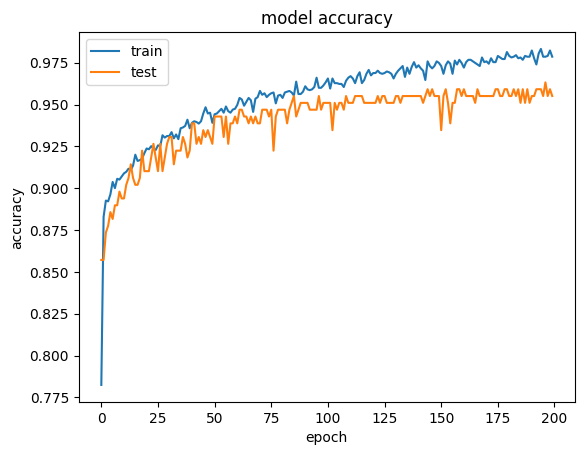

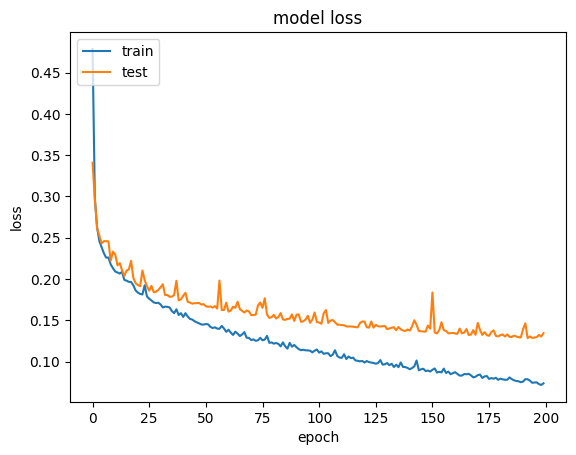

Dataset pair  2 !
Epoch 1/200
36/36 [==============================] - 13s 224ms/step - loss: 0.6190 - accuracy: 0.7362 - val_loss: 0.3639 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 202ms/step - loss: 0.3306 - accuracy: 0.8572 - val_loss: 0.2576 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2796 - accuracy: 0.8804 - val_loss: 0.2264 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 205ms/step - loss: 0.2594 - accuracy: 0.8897 - val_loss: 0.2094 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 204ms/step - loss: 0.2498 - accuracy: 0.8915 - val_loss: 0.1998 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 215ms/step - loss: 0.2402 - accuracy: 0.8994 - val_loss: 0.1991 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 7/200
36/36 [==========================

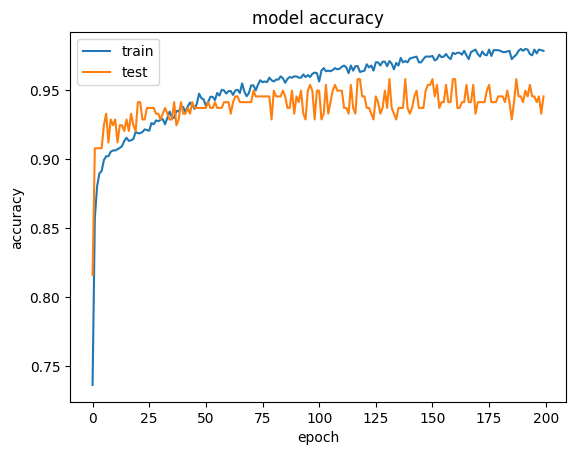

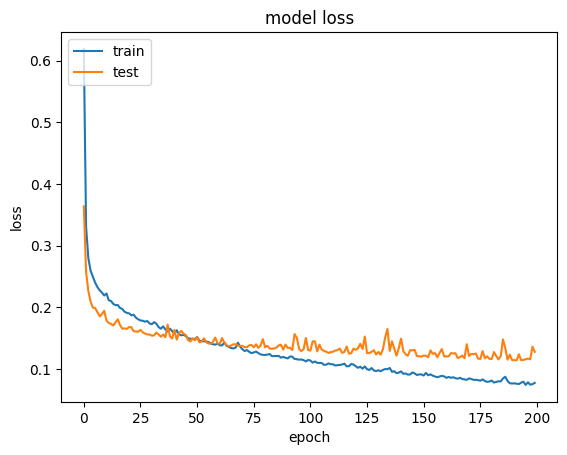

Dataset pair  3 !
Epoch 1/200
36/36 [==============================] - 13s 229ms/step - loss: 0.4584 - accuracy: 0.7928 - val_loss: 0.3594 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 218ms/step - loss: 0.2815 - accuracy: 0.8822 - val_loss: 0.3077 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 222ms/step - loss: 0.2486 - accuracy: 0.8952 - val_loss: 0.2898 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 206ms/step - loss: 0.2349 - accuracy: 0.8943 - val_loss: 0.2785 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 205ms/step - loss: 0.2277 - accuracy: 0.8980 - val_loss: 0.2718 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 217ms/step - loss: 0.2206 - accuracy: 0.9026 - val_loss: 0.2661 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 7/200
36/36 [==========================

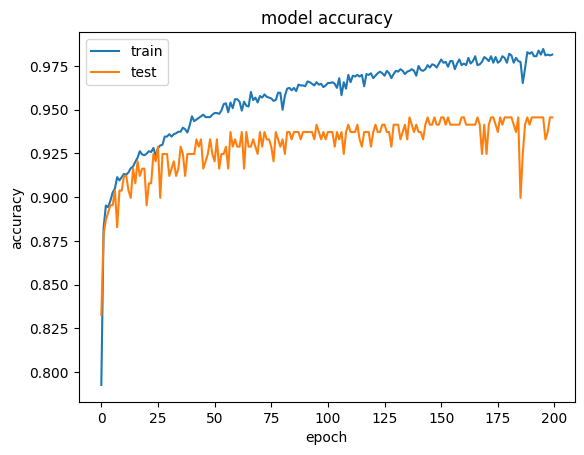

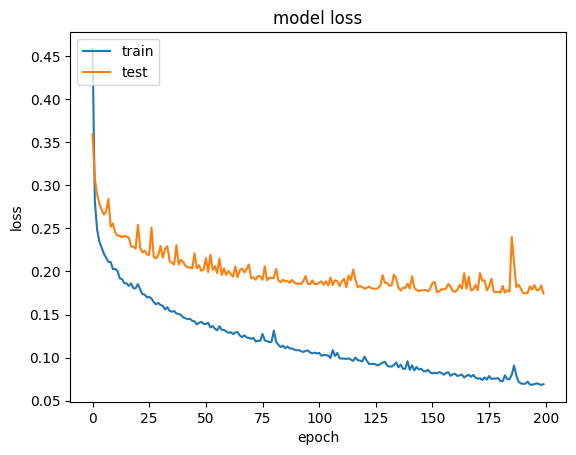

Dataset pair  4 !
Epoch 1/200
36/36 [==============================] - 13s 240ms/step - loss: 0.3622 - accuracy: 0.8484 - val_loss: 0.3173 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 200ms/step - loss: 0.2505 - accuracy: 0.8989 - val_loss: 0.2923 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2307 - accuracy: 0.8985 - val_loss: 0.2861 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 222ms/step - loss: 0.2250 - accuracy: 0.9064 - val_loss: 0.2773 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 205ms/step - loss: 0.2169 - accuracy: 0.9064 - val_loss: 0.2768 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 204ms/step - loss: 0.2111 - accuracy: 0.9073 - val_loss: 0.2653 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 7/200
36/36 [==========================

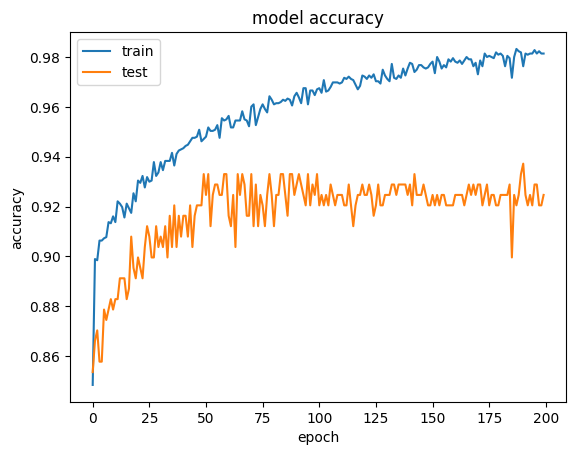

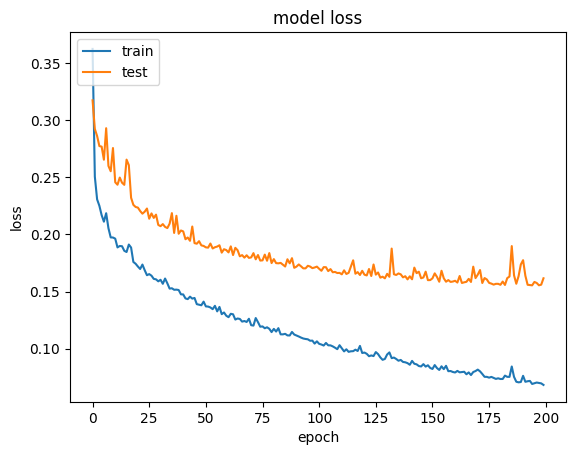

Dataset pair  5 !
Epoch 1/200
36/36 [==============================] - 12s 229ms/step - loss: 0.4438 - accuracy: 0.8011 - val_loss: 0.3089 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 204ms/step - loss: 0.2824 - accuracy: 0.8795 - val_loss: 0.2635 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2515 - accuracy: 0.8934 - val_loss: 0.2414 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2373 - accuracy: 0.8966 - val_loss: 0.2300 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 220ms/step - loss: 0.2344 - accuracy: 0.8989 - val_loss: 0.2225 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 201ms/step - loss: 0.2236 - accuracy: 0.9036 - val_loss: 0.2192 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 7/200
36/36 [==========================

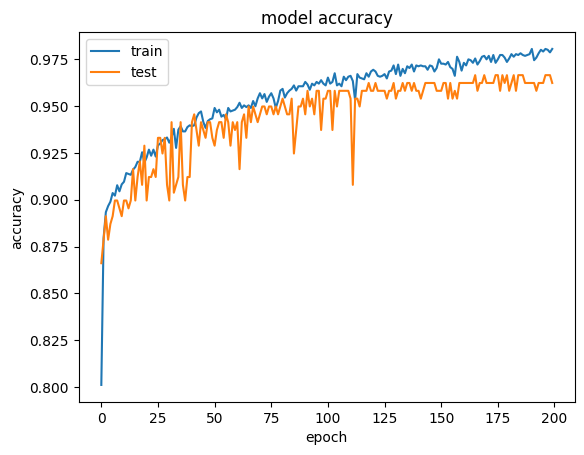

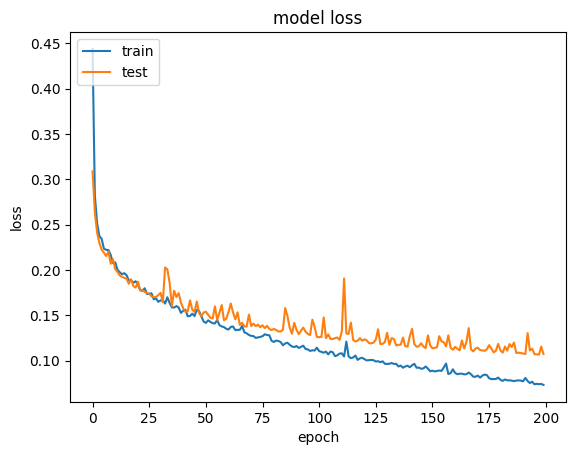

Dataset pair  6 !
Epoch 1/200
36/36 [==============================] - 13s 227ms/step - loss: 0.3816 - accuracy: 0.8382 - val_loss: 0.3063 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 201ms/step - loss: 0.2645 - accuracy: 0.8911 - val_loss: 0.2696 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 208ms/step - loss: 0.2433 - accuracy: 0.8962 - val_loss: 0.2598 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 209ms/step - loss: 0.2355 - accuracy: 0.9013 - val_loss: 0.2477 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2245 - accuracy: 0.9050 - val_loss: 0.2431 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 218ms/step - loss: 0.2180 - accuracy: 0.9091 - val_loss: 0.2415 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 7/200
36/36 [==========================

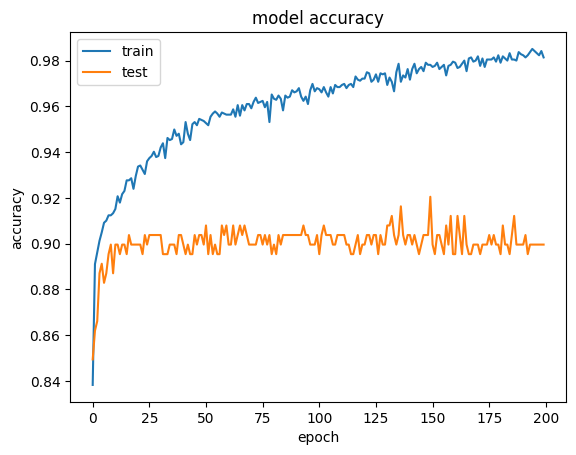

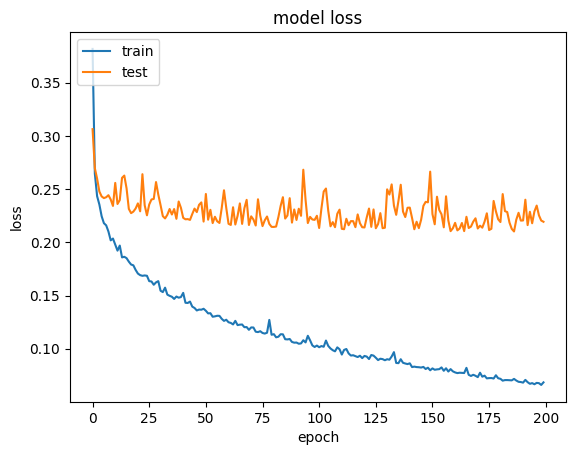

Dataset pair  7 !
Epoch 1/200
36/36 [==============================] - 13s 228ms/step - loss: 0.4088 - accuracy: 0.8234 - val_loss: 0.2557 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 202ms/step - loss: 0.2745 - accuracy: 0.8827 - val_loss: 0.2140 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 222ms/step - loss: 0.2483 - accuracy: 0.8869 - val_loss: 0.2086 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 209ms/step - loss: 0.2386 - accuracy: 0.8929 - val_loss: 0.1980 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 207ms/step - loss: 0.2314 - accuracy: 0.8971 - val_loss: 0.1960 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 218ms/step - loss: 0.2230 - accuracy: 0.9022 - val_loss: 0.1915 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 7/200
36/36 [==========================

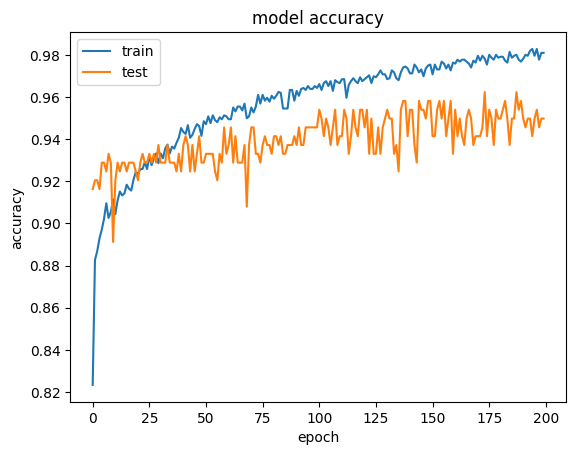

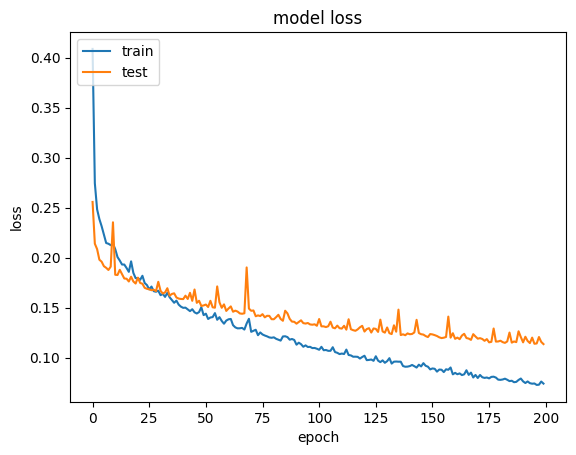

Dataset pair  8 !
Epoch 1/200
36/36 [==============================] - 13s 226ms/step - loss: 0.4827 - accuracy: 0.7863 - val_loss: 0.3323 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 2/200
36/36 [==============================] - 8s 205ms/step - loss: 0.3013 - accuracy: 0.8753 - val_loss: 0.2849 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 3/200
36/36 [==============================] - 8s 224ms/step - loss: 0.2611 - accuracy: 0.8915 - val_loss: 0.2766 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 4/200
36/36 [==============================] - 8s 210ms/step - loss: 0.2468 - accuracy: 0.8911 - val_loss: 0.2652 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 5/200
36/36 [==============================] - 8s 205ms/step - loss: 0.2349 - accuracy: 0.8975 - val_loss: 0.2656 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 6/200
36/36 [==============================] - 8s 217ms/step - loss: 0.2294 - accuracy: 0.9017 - val_loss: 0.2585 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 7/200
36/36 [==========================

In [ ]:
EPOCHS = 200

# DON'T FORGET THAT THE CURRENT CODE LETS THE CONV5 LAYER OF RESNET BE FINE-TUNED
for model_name, base_model, learning_rate in models:
  print("Training ", model_name, "!")
  new_models, histories = k_fold_cross_validate(
      datasets=datasets,
      model_name=model_name,
      base_model=base_model,
      epochs=EPOCHS,
      learning_rate = learning_rate,
      trainable=False,
      binary_or_two_class="binary",
      show_hist_after_each_train=True
  )

In [ ]:
!ls logs/*

In [ ]:
# Amazing code from DTrimarchi10 obtained from https://github.com/DTrimarchi10/confusion_matrix allowing me to make a confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
# Characteristic of validation dataset
# first loop through the entire validation set
# keep track of all dom and nondom images, putting them into two sections
# show all dom images, and all nondom images, as each a single grid using show_grid_image
num_dom, num_non_dom = 0, 0
dom_imgs, non_dom_imgs = [], []

# parse the dataset to find all dominant images and all non-dominant images
it = iter(val_ds)

for imgs, labels in it:

  for i in range(len(imgs)):
    img, label = imgs[i], labels[i]

    if int(label) == 0:
      num_dom += 1
      dom_imgs.append(img)
    else:
      num_non_dom += 1
      non_dom_imgs.append(img)

print("num_dom: ", num_dom, "; num_non_dom: ", num_non_dom)

# show all dominant imgs
dom_imgs_tensor = tf.stack(dom_imgs, axis=0)
print("dom_imgs:")
show_image_grid(dom_imgs_tensor, 10)

# show all non-dominant imgs
non_dom_imgs_tensor = tf.stack(non_dom_imgs, axis=0)
print("nondom_imgs:")
show_image_grid(non_dom_imgs_tensor, 10)

In [ ]:
#Evaluating the model. Gotta check:
# - accuracy
# - precision ( True positive-TP / [TP + False positive-FP] )
# - recall ( TP / [TP + False negative-FN] )
# - F1score, if the ratio of positive and negatives in dataset are umbalanced?
# Also consider Area Under the Curve.
# We will use a validation dataset (dataset isolated from training process and used to measure performance of model)

# Function that evaluates a given model's accuracy, precision, recall and F1score on our validation dataset
def evaluate(model, eval_ds):
  predictions = np.array([])
  labels =  np.array([])

  binary_or_two_class = "binary" if (model.output.shape[-1] == 1) else "two_class"

  for x, y in eval_ds:

    if binary_or_two_class == "binary":
      threshold = tf.constant(0.5)
      prob_pred = tf.reshape(model.predict(x), [len(x)])
      binary_pred = tf.cast( (prob_pred>threshold), dtype=tf.float32)*1
    else:
      binary_pred = tf.argmax(model.predict(x), axis=-1)

    predictions = np.concatenate([predictions, binary_pred])
    labels = np.concatenate([labels, y])
  cm = confusion_matrix(labels, predictions)
  make_confusion_matrix(cm)

# Actual evaluation
print("All models: ", new_models.keys())

for model_name in new_models.keys():
  print("Evaluated model: ", model_name)
  m = new_models[model_name]
  evaluate(m, eval_ds=val_ds)

In [ ]:
# Store all activations of the layer following Global Average Pooling 2D to be used for t-SNE visualization

"""
General idea:
1) make a dataset which holds all data used in this experiment
2) pass these data through the trained network and spit out all data at the last layer before dense layer
3) store all those data into a csv? Using pandas?
4) Then do something with t-SNE to visualize the result into lower dimensions.
"""
